In this notebook, we try to implement a version of WFC that uses BDDs.

In [ ]:
!pip install omega

In [1]:
%pylab inline
from tqdm.notebook import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'tqdm'

We'll start by trying to model the chess domain.

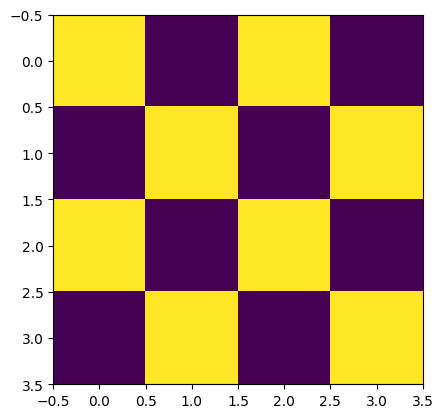

In [2]:
chess_grid = array([
    [1,0,1,0],
    [0,1,0,1],
    [1,0,1,0],
    [0,1,0,1],
])

imshow(chess_grid);

In [3]:
unique_tiles = unique(chess_grid.ravel())
unique_tiles

array([0, 1])

In [4]:
v_adj = h_adj = [[0,1],[1,0]]
v_adj, h_adj

([[0, 1], [1, 0]], [[0, 1], [1, 0]])

# Setup the BDD context

In [5]:
N = 10

In [6]:
from omega.symbolic.fol import Context

T = len(unique_tiles)

variables = {}
locations = {}
for i in range(N):
  for j in range(N):
    var = f"assign_{i}_{j}"
    variables[var] = (0,T-1)
    locations[var] = (i,j)

context = Context()
context.declare(**variables)
context.bdd.configure(reordering=False);

`omega.symbolic.symbolic` failed to import `dd.cudd`.
Will use `dd.autoref`.


In [7]:
%%time
generator = context.true

dag_sizes = []
dag_sizes.append(generator.dag_size)

for i in range(N-1):
  for j in range(N):
    h_cases = context.false
    for u,v in h_adj:
      h_cases |= context.add_expr(f"assign_{i}_{j} = {u} & assign_{i+1}_{j} = {v}")
    generator &= h_cases
    dag_sizes.append(generator.dag_size)

for i in range(N):
  for j in range(N-1):
    v_cases = context.false
    for u,v in v_adj:
      v_cases |= context.add_expr(f"assign_{i}_{j} = {u} & assign_{i}_{j+1} = {v}")
    generator &= v_cases
    dag_sizes.append(generator.dag_size)

generator.dag_size

CPU times: user 27 s, sys: 5.78 s, total: 32.8 s
Wall time: 33.5 s


199

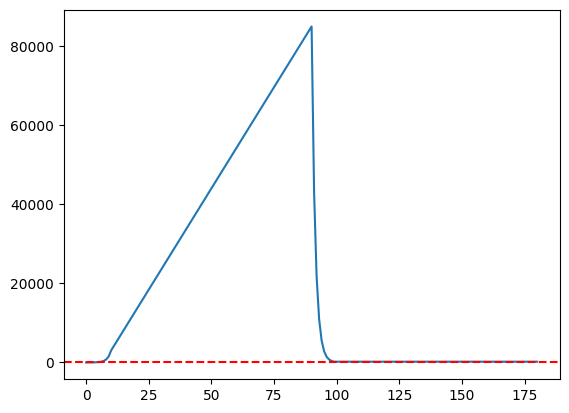

In [ ]:
plot(dag_sizes); axhline(dag_sizes[-1],c='r',linestyle='dashed');

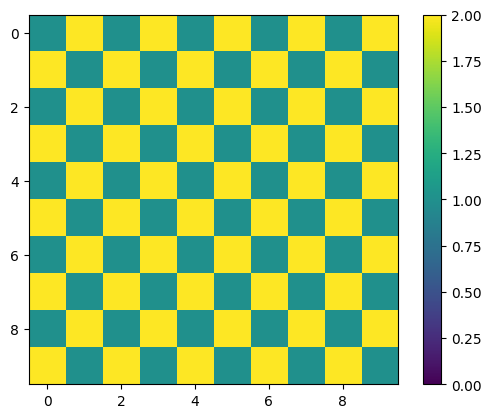

In [ ]:
sol = context.pick(generator)
img = zeros((N,N),dtype='uint8')
for var, val in sol.items():
  i,j = locations[var]
  img[i,j] = val + 1

imshow(img,vmin=0,vmax=2); colorbar();

In [ ]:
%%time
one_cell = context.true
h_cases = context.false
for u,v in h_adj:
  h_cases |= context.add_expr(f"assign_0_0 = {u} & assign_1_0 = {v}")
v_cases = context.false
for u,v in h_adj:
  v_cases |= context.add_expr(f"assign_0_0 = {u} & assign_0_1 = {v}")

h_cases_shifted = context.let({'assign_0_0': 'assign_0_1', 'assign_1_0': 'assign_1_1'}, h_cases)
v_cases_shifted = context.let({'assign_0_0': 'assign_1_0', 'assign_0_1': 'assign_1_1'}, v_cases)

one_cell &= h_cases
one_cell &= v_cases
one_cell &= h_cases_shifted
one_cell &= v_cases_shifted

generator2 = context.true
dag_sizes2 = []
dag_sizes2.append(generator2.dag_size)

for i in range(N-1):
  for j in range(N-1):
    if i == 0 and j == 0:
      generator2 &= one_cell
    else:
      generator2 &= context.let({'assign_0_0': f'assign_{i}_{j}',
                                'assign_0_1': f'assign_{i}_{j+1}',
                                'assign_1_0': f'assign_{i+1}_{j}',
                                'assign_1_1': f'assign_{i+1}_{j+1}'
                                }, one_cell)

    dag_sizes2.append(generator2.dag_size)


generator2.dag_size

CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 11.6 ms


199

In [ ]:
assert generator == generator2

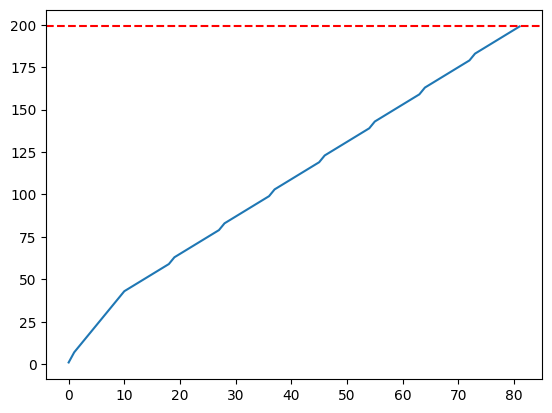

In [ ]:
plot(dag_sizes2); axhline(dag_sizes2[-1],c='r', linestyle='dashed');

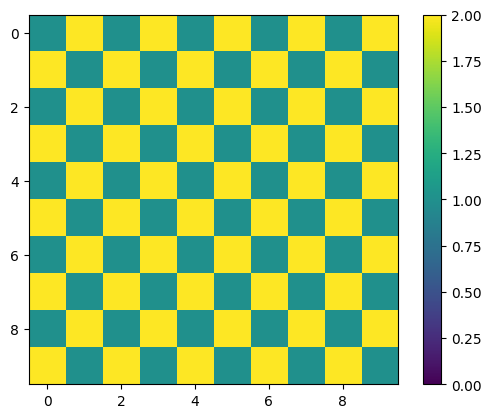

In [ ]:
sol = context.pick(generator2)
img = zeros((N,N),dtype='uint8')
for var, val in sol.items():
  i,j = locations[var]
  img[i,j] = val + 1

imshow(img,vmin=0,vmax=2); colorbar();

Let's explore how `let` works. It is like `compose`, and `compose` is like a larger expression involving `exist` and conjunction with some equivalence constraint.

In [ ]:
import dd
engine = dd.bdd.BDD()

In [ ]:
engine.declare(*list(variables.keys()))

In [ ]:
d = engine.add_expr("assign_0_0 ^ assign_0_1")

In [ ]:
list(engine.pick_iter(d))

[{'assign_0_0': False, 'assign_0_1': True},
 {'assign_0_0': True, 'assign_0_1': False}]

In [ ]:
d2 = engine.compose(d, {'assign_0_0': engine.add_expr('assign_5_5')})
engine.support(d2)

{'assign_0_1', 'assign_5_5'}

In [ ]:
list(engine.pick_iter(d2))

[{'assign_0_1': False, 'assign_5_5': True},
 {'assign_0_1': True, 'assign_5_5': False}]

In [ ]:
d3 = engine.exist(['assign_0_0'], engine.apply('&', d, engine.add_expr(f'assign_0_0 <-> assign_5_5')))
list(engine.pick_iter(d3))

[{'assign_0_1': False, 'assign_5_5': True},
 {'assign_0_1': True, 'assign_5_5': False}]

Practice renaming in a very simple context.

In [ ]:
engine2 = dd.BDD()
engine2.declare(*'abc')

In [ ]:
d = engine2.add_expr('a -> b')
engine2.support(d)

{'a', 'b'}

In [ ]:
d2 = engine2.let({'b': 'c'}, d)
engine2.support(d2)

{'a', 'c'}